# Dimuon pairs with L1-trigger scouting data

Contact: m.migliorini@cern.ch <br>

In [1]:
spark

## Import packages and define constants

In [2]:
import pandas as pd
import numpy as np

import pyspark.sql.functions as F
from pyspark.sql.functions import when, col

import matplotlib.pyplot as plt
import matplotlib as mpl

# install mplhep if needed, only used for plot styling
import mplhep as hep
hep.style.use(hep.style.CMS)

In [3]:
DURATION_BX = 25 # BX counter duration in ns
ORBIT_BX = 3564  # number of BX in an orbit

In [29]:
LHC_FILL = '12345'
CMS_RUN = '362653'

## Load data

In [4]:
dataset_path = '/eos/cms/store/cmst3/group/daql1scout/run3/funpack/362653/scout_GMT_362653_*.pqt'

In [5]:
# number of files
!ls $dataset_path | wc -l

603


In [6]:
df = (
    spark
    .read
    .parquet('root://eosuser.cern.ch/'+dataset_path)
)

In [7]:
df.printSchema()

root
 |-- orbit: long (nullable = true)
 |-- bx: integer (nullable = true)
 |-- interm: byte (nullable = true)
 |-- pt: float (nullable = true)
 |-- ptuncon: float (nullable = true)
 |-- charge: byte (nullable = true)
 |-- iso: byte (nullable = true)
 |-- index: byte (nullable = true)
 |-- qual: byte (nullable = true)
 |-- phi: float (nullable = true)
 |-- phie: float (nullable = true)
 |-- eta: float (nullable = true)
 |-- etae: float (nullable = true)
 |-- dxy: byte (nullable = true)



In [8]:
print('Number of muons in the dataset: %s'%df.count())

Number of muons in the dataset: 12598897340


In [9]:
df = (
    df
    .withColumn('region', 
              when((df['index']>=36)&(df['index']<=70), 'barrel') \
              .when(((df['index']>=0)&(df['index']<=16)) | ((df['index']>=90)&(df['index']<=107)), 'endcap') \
              .when((((df['index']>=17)&(df['index']<=35)) | ((df['index']>=71)&(df['index']<=89))), 'overlap') \
              .otherwise('invalid')
             )
)

In [10]:
regionCounts = (
    df
    .groupBy('region').count()
    .toPandas()
) 

In [11]:
regionCounts

region       count
0  overlap  2216935071
1   endcap  9641819401
2   barrel   740142868

In [12]:
max_orbit, min_orbit = df.select(F.max(df['orbit']), F.min(df['orbit'])).first()

run_time = (max_orbit-min_orbit) * ORBIT_BX * DURATION_BX * 10**(-9)
print("Run lasted {:.2f} seconds".format(run_time))

Run lasted 3526.91 seconds


In [13]:
# may be usefull to select specific intervals of the run
df = df.withColumn('deltaT', (df['orbit']-min_orbit)* ORBIT_BX * DURATION_BX * 10**(-9))

## Muon pairs

In [14]:
muons_df = (
    df
    .groupby(['orbit', 'bx']).agg(
        F.collect_list(F.struct('pt', 'qual', 'phie', 'phi', 'etae', 'eta', 'charge', 'index', 'region', 'dxy', 'ptuncon')).alias('muons'),
        F.count('bx').alias('nMuons')
    )
)

In [15]:
muons_df.printSchema()

root
 |-- orbit: long (nullable = true)
 |-- bx: integer (nullable = true)
 |-- muons: array (nullable = false)
 |    |-- element: struct (containsNull = false)
 |    |    |-- pt: float (nullable = true)
 |    |    |-- qual: byte (nullable = true)
 |    |    |-- phie: float (nullable = true)
 |    |    |-- phi: float (nullable = true)
 |    |    |-- etae: float (nullable = true)
 |    |    |-- eta: float (nullable = true)
 |    |    |-- charge: byte (nullable = true)
 |    |    |-- index: byte (nullable = true)
 |    |    |-- region: string (nullable = false)
 |    |    |-- dxy: byte (nullable = true)
 |    |    |-- ptuncon: float (nullable = true)
 |-- nMuons: long (nullable = false)



In [16]:
# select only muon pairs, SS/OS and other cuts applied later
dimuons_df = muons_df.where(muons_df['nMuons']==2)

In [17]:
dimuon_flat_df = (
    dimuons_df
    # used to select muon pairs excluding overlap region
    #.where(
    #    F.size(F.filter('muons', lambda muon: ((muon.region=='endcap')|(muon.region=='barrel')))) == 2
    #)
    # flatten dimuons
    .select([col('muons')[0], col('muons')[1]])
    .withColumn('pt1', col('Muons[0].pt'))
    .withColumn('phi1', col('Muons[0].phie'))
    .withColumn('eta1', col('Muons[0].etae'))
    .withColumn('eta_1', col('Muons[0].eta'))
    .withColumn('phi_1', col('Muons[0].phi'))
    .withColumn('c1', col('Muons[0].charge'))
    .withColumn('q1', col('Muons[0].qual'))
    .withColumn('dxy1', col('Muons[0].dxy'))
    .withColumn('pu1', col('Muons[0].ptuncon'))
    .withColumn('region1', col('Muons[0].region'))
    .withColumn('pt2', col('Muons[1].pt'))
    .withColumn('phi2', col('Muons[1].phie'))
    .withColumn('eta2', col('Muons[1].etae'))
    .withColumn('eta_2', col('Muons[1].eta'))
    .withColumn('phi_2', col('Muons[1].phi'))
    .withColumn('c2', col('Muons[1].charge'))
    .withColumn('q2', col('Muons[1].qual'))
    .withColumn('dxy2', col('Muons[1].dxy'))
    .withColumn('pu2', col('Muons[1].ptuncon'))
    .withColumn('region2', col('Muons[1].region'))
    .drop('Muons[0]', 'Muons[1]')
)

In [18]:
# add invariant mass, can also be recomputed later
dimuon_flat_df = dimuon_flat_df.withColumn('m', F.sqrt(2*col('pt1')*col('pt2')*(F.cosh(col('eta1')-col('eta2'))-F.cos(col('phi1')-col('phi2')))))

In [19]:
## save results of the preprocessing either on HDFS or eos
# write_parquet() triggers the computations, which takes around 20 mins to process the entire run
dimuon_flat_df.write.parquet('hdfs://analytix/user/matteomi/dimuons.pqt', mode='overwrite')

23/01/12 11:22:00 ERROR YarnScheduler: Lost executor 1 on ithdp1109.cern.ch: Container from a bad node: container_e156_1671906036951_17818_01_000002 on host: ithdp1109.cern.ch. Exit status: 137. Diagnostics: [2023-01-12 11:21:59.963]Container killed on request. Exit code is 137
[2023-01-12 11:22:00.154]Container exited with a non-zero exit code 137. 
[2023-01-12 11:22:00.158]Killed by external signal
.
23/01/12 11:22:00 WARN YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 1 for reason Container from a bad node: container_e156_1671906036951_17818_01_000002 on host: ithdp1109.cern.ch. Exit status: 137. Diagnostics: [2023-01-12 11:21:59.963]Container killed on request. Exit code is 137
[2023-01-12 11:22:00.154]Container exited with a non-zero exit code 137. 
[2023-01-12 11:22:00.158]Killed by external signal
.
23/01/12 11:22:00 WARN TaskSetManager: Lost task 192.0 in stage 13.0 (TID 4635) (ithdp1109.cern.ch executor 1): ExecutorLostFailure (executor 1 exit

## Reload dataset and cache it

It is possible to start from here in the next sessions.
Reading the parquet file from HDFS should be faster than working from EOS.

In [20]:
# cache the dataframe. Notice that there must be enough workers/memory to store
# it in workers' memory. Once cached processing is faster
dimuonLoaded = spark.read.parquet('dimuons.pqt').persist()

In [23]:
print('Number of dimuon pairs: %i' % dimuonLoaded.count())

Number of dimuon pairs: 1322039167


In [25]:
print('Number of OS dimuon pairs: %i' % (
        (dimuonLoaded
            .where((dimuonLoaded['c1'] != dimuonLoaded['c2']))
         .count())
    )
)

Number of OS dimuon pairs: 621051853


In [26]:
print('Number of SS dimuon pairs: %i' % (
        (dimuonLoaded
            .where((dimuonLoaded['c1'] == dimuonLoaded['c2']))
         .count())
    )
)

Number of SS dimuon pairs: 700987314


Utils function to compute histograms using spark

In [24]:
def computeHistogram(df: "DataFrame", value_col: str, min: float, max: float, bins: int) -> "DataFrame":
    """ This is a dataframe function to compute the count/frequecy histogram of a column
        
        Parameters
        ----------
        df: the dataframe with the data to compute
        value_col: column name on which to compute the histogram
        min: minimum value in the histogram
        max: maximum value in the histogram
        bins: number of histogram buckets to compute
        
        Output DataFrame
        ----------------
        bucket: the bucket number, range from 1 to bins (included)
        value: midpoint value of the given bucket
        count: number of values in the bucket        
    """
    step = (max - min) / bins
    # this will be used to fill in for missing buckets, i.e. buckets with no corresponding values
    df_buckets = spark.sql(f"select id+1 as bucket from range({bins})")
    
    histdf = (df
              .selectExpr(f"width_bucket({value_col}, {min}, {max}, {bins}) as bucket")
              .groupBy("bucket")
              .count()
              .join(df_buckets, "bucket", "right_outer") # add missing buckets and remove buckets out of range
              .selectExpr("bucket", f"{min} + (bucket - 1/2) * {step} as value", # use center value of the buckets
                          "nvl(count, 0) as count") # buckets with no values will have a count of 0
              .orderBy("bucket")
             )
    return histdf

Perform selections and compute histograms

In [62]:
h_min, h_max = 0.1, 300
h_bins = h_max*5 

filtered_base = (
    dimuonLoaded
    .where((dimuonLoaded['dxy1']==0)&(dimuonLoaded['dxy2']==0))
    .where((dimuonLoaded['pt2']>4) & (dimuonLoaded['pt1']>4)) # cut low pt, contains garbage from BMTF
    .where((dimuonLoaded['eta1']<2.4)&(dimuonLoaded['eta2']<2.4))
    .where((dimuonLoaded['q1']>7)&(dimuonLoaded['q2']>7)) #quality cut
)

filtered = (
    filtered_base
    .where((dimuonLoaded['c1'] != dimuonLoaded['c2']))
)

histo = computeHistogram(filtered, 'm', h_min, h_max, h_bins)
histopd_os = histo.toPandas()

filtered = (
    filtered_base
    .where((dimuonLoaded['c1'] == dimuonLoaded['c2']))
)

histo = computeHistogram(filtered, 'm', h_min, h_max, h_bins)
histopd_ss = histo.toPandas()

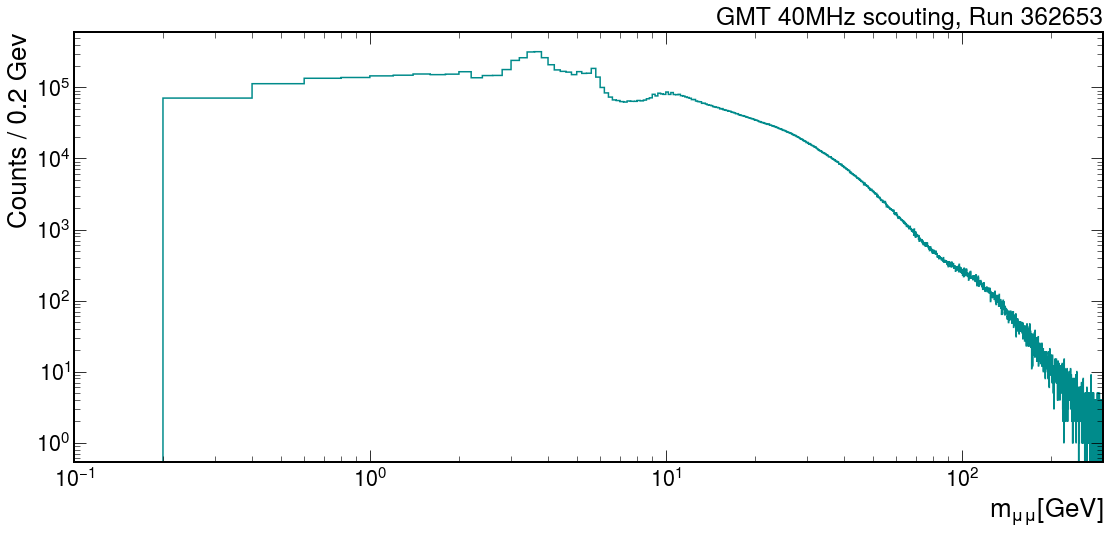

In [63]:
plt.figure(figsize=(16,8))

bins = histopd_os['value'].values
counts_os = histopd_os['count'].values

hep.histplot(counts_os[:-1], bins, color='darkcyan')

plt.xlabel("$m_{\mu\mu} [GeV]$")
plt.ylabel("Counts / 0.2 Gev")
#hep.cms.text("Preliminary", loc=0)
hep.cms.lumitext("GMT 40MHz scouting, Run %s" % (CMS_RUN))


plt.semilogy(); plt.semilogx(); plt.xlim(h_min,h_max)

plt.tight_layout()
plt.show()

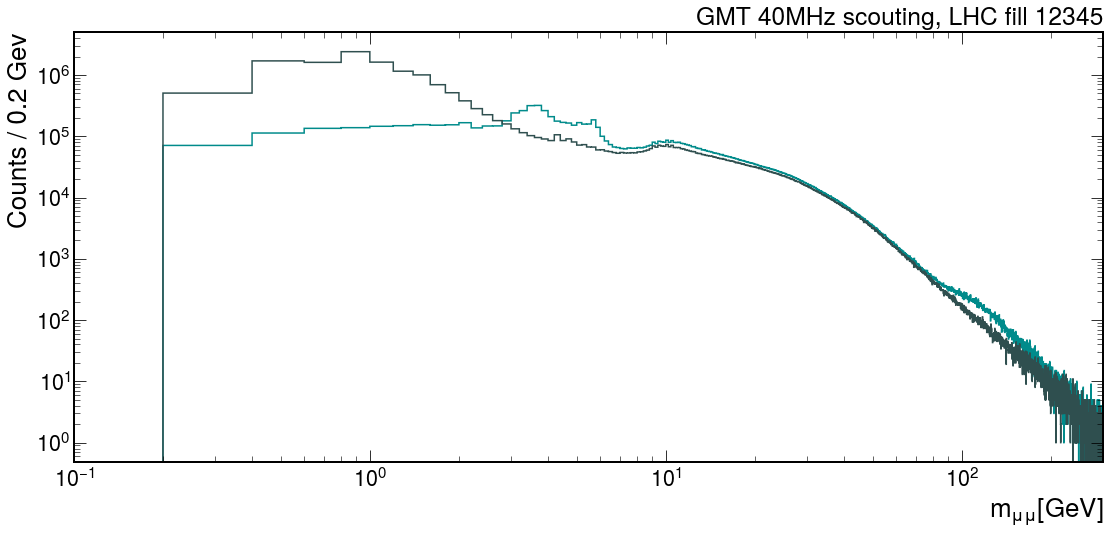

In [64]:
plt.figure(figsize=(16,8))

bins = histopd_os['value'].values
counts_os = histopd_os['count'].values
counts_ss = histopd_ss['count'].values

hep.histplot([counts_os[:-1], counts_ss[:-1]], bins, color=['darkcyan', 'darkslategray'], label=['OS', 'SS'])

plt.xlabel("$m_{\mu\mu} [GeV]$")
plt.ylabel("Counts / 0.2 Gev")
hep.cms.lumitext("GMT 40MHz scouting, LHC fill %s" % (LHC_FILL))


plt.semilogy(); plt.semilogx(); plt.xlim(h_min,h_max)
plt.tight_layout()

plt.show()

# Barrel only

In [65]:
h_min, h_max = 0.1, 300
h_bins = h_max*5 

filtered_base = (
    dimuonLoaded
    .where((dimuonLoaded['region1']=='barrel')&((dimuonLoaded['region2']=='barrel')))
    .where((dimuonLoaded['dxy1']==0)&(dimuonLoaded['dxy2']==0))
    .where((dimuonLoaded['pt2']>4) & (dimuonLoaded['pt1']>4)) # cut low pt, contains garbage from BMTF
    .where((dimuonLoaded['q1']>7)&(dimuonLoaded['q2']>7)) #quality cut
)

filtered = (
    filtered_base
    .where((dimuonLoaded['c1'] != dimuonLoaded['c2']))
)

histo = computeHistogram(filtered, 'm', h_min, h_max, h_bins)
histopd_os = histo.toPandas()

filtered = (
    filtered_base
    .where((dimuonLoaded['c1'] == dimuonLoaded['c2']))
)

histo = computeHistogram(filtered, 'm', h_min, h_max, h_bins)
histopd_ss = histo.toPandas()

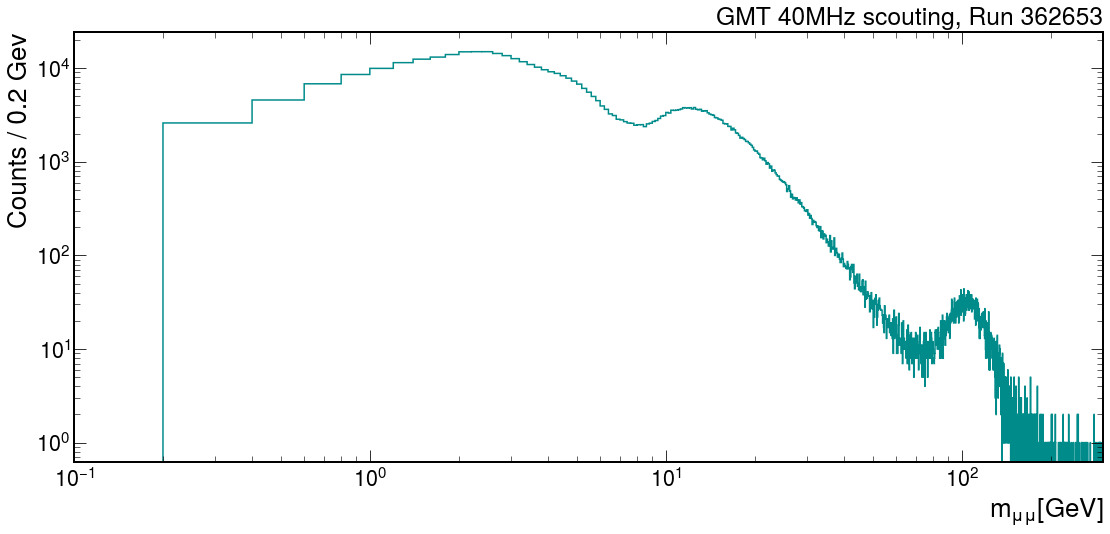

In [66]:
plt.figure(figsize=(16,8))

bins = histopd_os['value'].values
counts_os = histopd_os['count'].values

hep.histplot(counts_os[:-1], bins, color='darkcyan')

plt.xlabel("$m_{\mu\mu} [GeV]$")
plt.ylabel("Counts / 0.2 Gev")
#hep.cms.text("Preliminary", loc=0)
hep.cms.lumitext("GMT 40MHz scouting, Run %s" % (CMS_RUN))


plt.semilogy(); plt.semilogx(); plt.xlim(h_min,h_max)

plt.tight_layout()
plt.show()

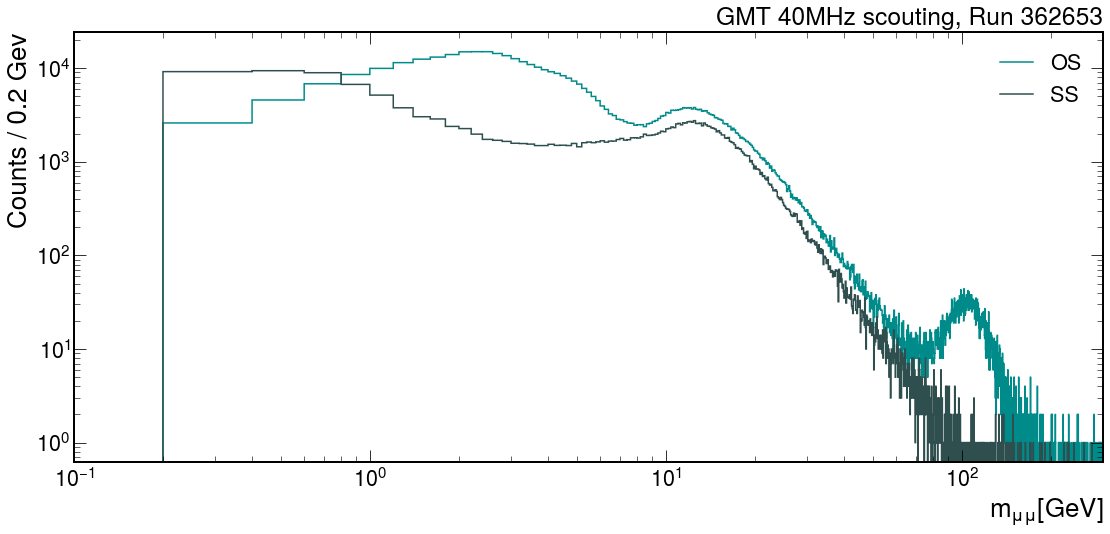

In [67]:
plt.figure(figsize=(16,8))

bins = histopd_os['value'].values
counts_os = histopd_os['count'].values
counts_ss = histopd_ss['count'].values

hep.histplot([counts_os[:-1], counts_ss[:-1]], bins, color=['darkcyan', 'darkslategray'], label=['OS', 'SS'])

plt.xlabel("$m_{\mu\mu} [GeV]$")
plt.ylabel("Counts / 0.2 Gev")
hep.cms.lumitext("GMT 40MHz scouting, Run %s" % (CMS_RUN))

plt.semilogy(); plt.semilogx(); plt.xlim(h_min,h_max)
plt.legend()
plt.tight_layout()
plt.show()

# Endcap only

In [68]:
h_min, h_max = 0.1, 300
h_bins = h_max*5

filtered_base = (
    dimuonLoaded
    .where((dimuonLoaded['region1']=='endcap')&((dimuonLoaded['region2']=='endcap')))
    .where((dimuonLoaded['pt2']>4) & (dimuonLoaded['pt1']>4)) # cut low pt, contains garbage from BMTF
    #.where(F.abs(dimuonLoaded['eta1']-dimuonLoaded['eta2'])<1.4)
    .where((dimuonLoaded['q1']>4)&(dimuonLoaded['q2']>4)) #quality cut
)

filtered = (
    filtered_base
    .where((dimuonLoaded['c1'] != dimuonLoaded['c2']))
)

histo = computeHistogram(filtered, 'm', h_min, h_max, h_bins)
histopd_os = histo.toPandas()

filtered = (
    filtered_base
    .where((dimuonLoaded['c1'] == dimuonLoaded['c2']))
)

histo = computeHistogram(filtered, 'm', h_min, h_max, h_bins)
histopd_ss = histo.toPandas()

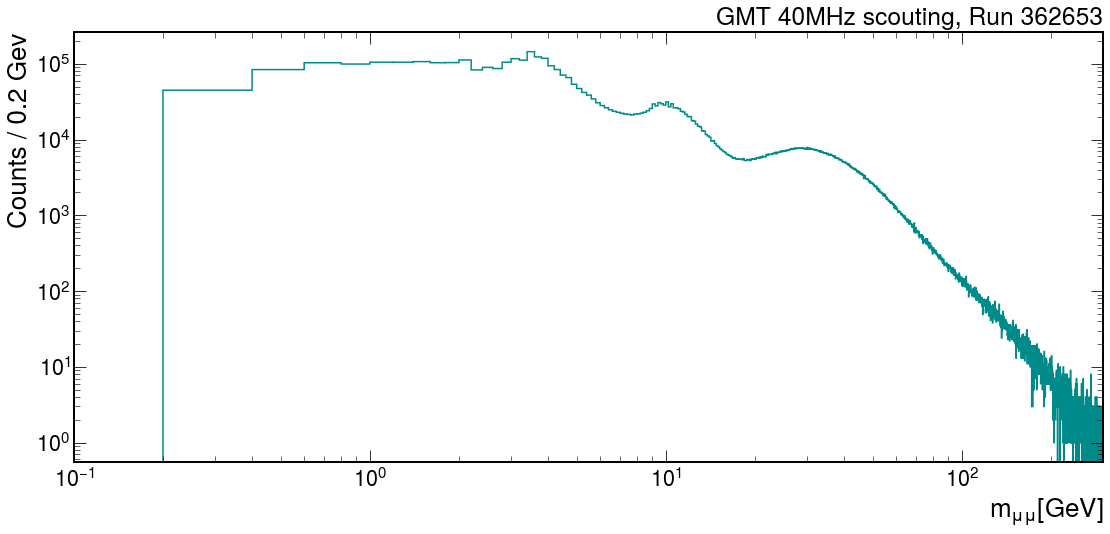

In [69]:
plt.figure(figsize=(16,8))

bins = histopd_os['value'].values
counts_os = histopd_os['count'].values

hep.histplot(counts_os[:-1], bins, color='darkcyan')

plt.xlabel("$m_{\mu\mu} [GeV]$")
plt.ylabel("Counts / 0.2 Gev")
#hep.cms.text("Preliminary", loc=0)
hep.cms.lumitext("GMT 40MHz scouting, Run %s" % (CMS_RUN))


plt.semilogy(); plt.semilogx(); plt.xlim(h_min,h_max)

plt.tight_layout()
plt.show()

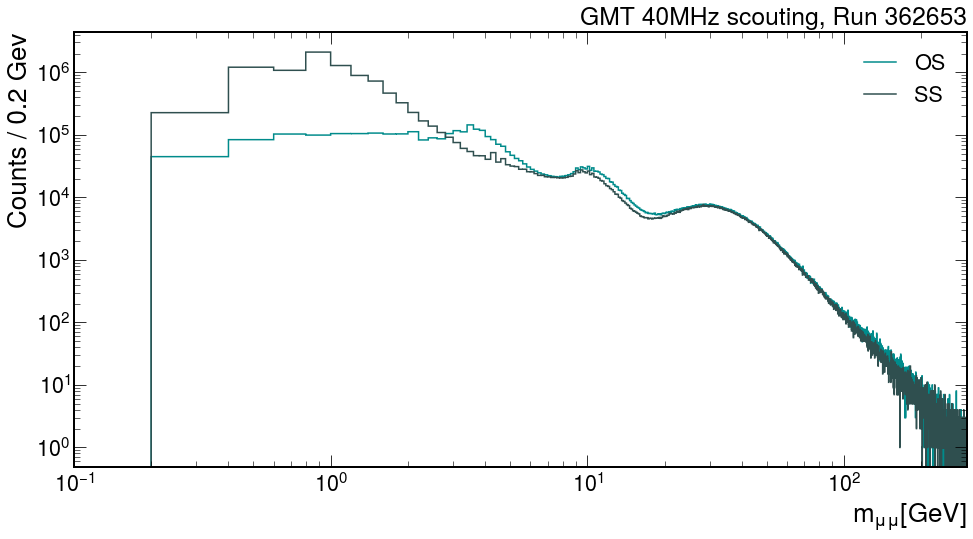

In [70]:
plt.figure(figsize=(16,8))

bins = histopd_os['value'].values
counts_os = histopd_os['count'].values
counts_ss = histopd_ss['count'].values

hep.histplot([counts_os[:-1], counts_ss[:-1]], bins, color=['darkcyan', 'darkslategray'], label=['OS', 'SS'])

plt.xlabel("$m_{\mu\mu} [GeV]$")
plt.ylabel("Counts / 0.2 Gev")
hep.cms.lumitext("GMT 40MHz scouting, Run %s" % (CMS_RUN))

plt.semilogy(); plt.semilogx(); plt.xlim(h_min,h_max)
plt.legend()
plt.show()